In [1]:
## - - - - - - - - - - - - - - - - - - - - - - - - - - -                                                    
##      import libraries                                                                                    
## - - - - - - - - - - - - - - - - - - - - - - - - - - -                                                    

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import griddata, UnivariateSpline
from matplotlib.pyplot import * # plotting library                                                          
import math
import pylab
from matplotlib import ticker
from mpmath import mp
import mpmath
from numpy import random
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import chi2
import random
from scipy.special import erfinv
from scipy.special import erf

## - - - - - - - - - - - - - - - - - - - - - - - - - - -                                                    
##      plotting properties                                                                                 
## - - - - - - - - - - - - - - - - - - - - - - - - - - -                                                    

plt.rcParams.update({
    'text.usetex': False,
    'font.family':'serif',
    'mathtext.fontset' : 'cm',
    'mathtext.rm': 'serif',
    'font.weight': 'normal',
    'axes.labelweight': 'normal',
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'xtick.major.size': 10.0,
    'xtick.minor.size': 5.0,
    'ytick.major.width': 1.5,
    'ytick.major.size': 10.0,
    'ytick.minor.size': 5.0,
    'font.size': 30})
plt.rcParams.update({'font.size': 20})



In [2]:
## basic parameters                                                                                         

m=40*1.66*1e-27
kb=1.38*1e-23
T=30
ev_in_J = 1.6021766348*1e-19 #J eV-1                                                                        
kbev = kb/ev_in_J # eV mol-1 K-1                                                                            
B = (1./(kbev*T))
A = math.sqrt(B/math.pi)
## Answer 1-2                                                                                               
RNG = np.random.default_rng(20230106)
print(B)

386.9991871497585


In [3]:
print(A)
print(B)
Nsim=10000
Emin=5e-6
Emax=0.01
steps = 1000
Energies = np.linspace(Emin,Emax,steps)

11.098903874476035
386.9991871497585


In [4]:
## Define the Gaussian shape for the fit later                                                              
def Gaussian_dist(x, mu, sigma):
    pref = 1 / sigma / np.sqrt(2 * np.pi)
    return pref * np.exp(- pow(x - mu, 2) / 2 / sigma / sigma)


def few(x,beta=B):
    ## ewinput and Binput are the given potential energy and B                                              
    ## Here we return the f(E_w) value at a given E_w                                                       
    amp=np.sqrt(beta/np.pi)
    return float(amp)/np.sqrt(x) * np.exp(-beta*x)

def expo(x, beta=B):
    return np.exp(-beta*x)

4953.985485668265


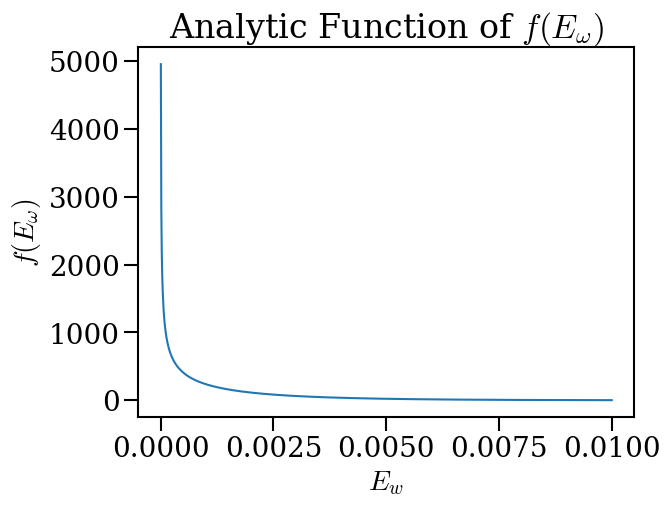

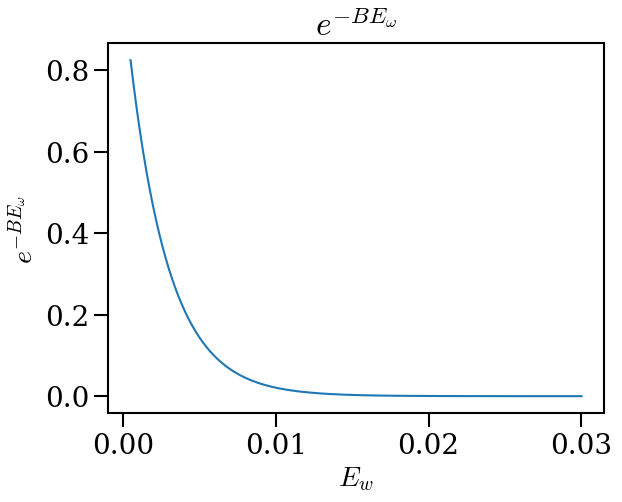

In [5]:
fmax=(few(Emin,B))
print(fmax)
y1 = few(Energies,B)

xx = np.linspace(5e-4,0.03,1000)
yy = expo(xx,B)

plt.plot(Energies, y1, label="")
plt.title("Analytic Function of $f(E_\omega)$")
#plt.legend()
plt.xlabel(r'$E_w$')
plt.ylabel(r'$f(E_\omega)$')
plt.show()

plt.plot(xx, yy, label="")
plt.title("$e^{- B E_\omega} $")
#plt.legend()
plt.xlabel(r'$E_w$')
plt.ylabel(r'$e^{- B E_\omega}$')
plt.show()

In [6]:
# Generating E_w with accept-reject method                                                                  

def ewgenerator(Binput):
    ewcut=Emax
    rx=np.random.uniform(0,ewcut)
    # The maximum for f(E_w) which we use as the height for the uniform envelope                            
    fmax=(few(Emin,Binput))
    ry=np.random.uniform(0,fmax)
    output=-1.0
    judge=False
    if ry<few(rx,Binput):
        output=rx
        judge=True

    return output,judge

print("EW generator defined")
ntest=10000
ew=list(range(ntest))

## Generating E_w                                                                                           
i=0
while i<ntest:
    ewtry,ewjudge=ewgenerator(B)
    if ewjudge==True:
        ew[i]=ewtry
        i+=1


EW generator defined


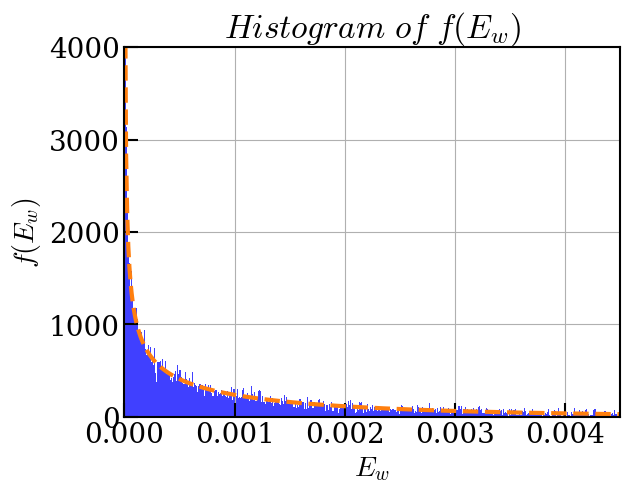

0.0012761547637738608
This is alpha: 0.49387085625777616
2.715053103929744e-06
skewness= 2.0468485056827017
kurtosis= 4.564121426354868
variance= 67466.66198902257 	 skewness= 9.68083979436711 	 kurtosis= 142.74601039548918


In [9]:
plt.figure(1)
plt.hist(ew, 1000, density=True, facecolor='b', alpha=0.75)
plot(Energies,y1,'--',lw=3)
plt.ylim([0,4000])
plt.xlim([0,0.0045])
plt.xlabel(r'$E_w$')
plt.ylabel(r'$f(E_w)$')
plt.title(r'$Histogram\ of\ f(E_w)$')
plt.tick_params(direction='in')
plt.grid(True)
plt.show()


ewavg=sum(ew)/len(ew)
alpha=ewavg/(kbev*T)
print(ewavg)
print("This is alpha: "+ str(alpha))

var=np.var(ew)
print(var)
import scipy.stats as stats
print('skewness=',skew(ew))
print('kurtosis=',kurtosis(ew))

Variance=np.var(few(Energies,B))
Skew=stats.skew(few(Energies,B))
Kurt=stats.kurtosis(few(Energies,B))
print('variance=',Variance,'\t skewness=',Skew,'\t kurtosis=',Kurt)



In [36]:
def LLH(ektest,Ttest):
    Loutput=0
    for i in range(0,len(ektest)):
        Loutput+=math.log(few(ektest[i],Ttest))
    return -Loutput

print (LLH(ew,250))

-57451.874054876855


[2.22948971e-03 1.51337980e-05 2.25575770e-04 ... 5.54341851e-04
 1.73026276e-03 5.59743517e-03]


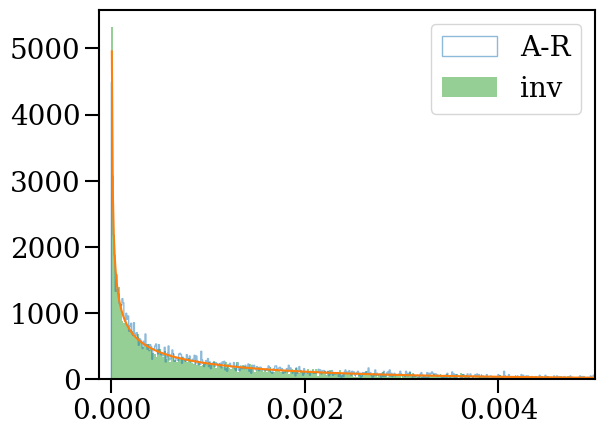

In [20]:
def invCDF(u,beta):
    # beta=1/(kb*T)                                                                                         
    return (1/beta)*((erfinv(u))**2)

ru=RNG.uniform(0,1,10000)
gen_inv=invCDF(ru,B)
print(gen_inv)
hist_bins=1000
plt.figure(1)
# plt.scatter(E_gen[0],E_gen[1],s=2,color="orange")                                                         
plt.hist(ew,1000,histtype="step",density=True,alpha=0.5,label="A-R")
plt.plot(Energies, y1)
plt.hist(gen_inv,hist_bins,density=True,alpha=0.5,label="inv")
plt.xlim([-0.05*0.0025, 2*0.0025])
plt.legend()
plt.show()


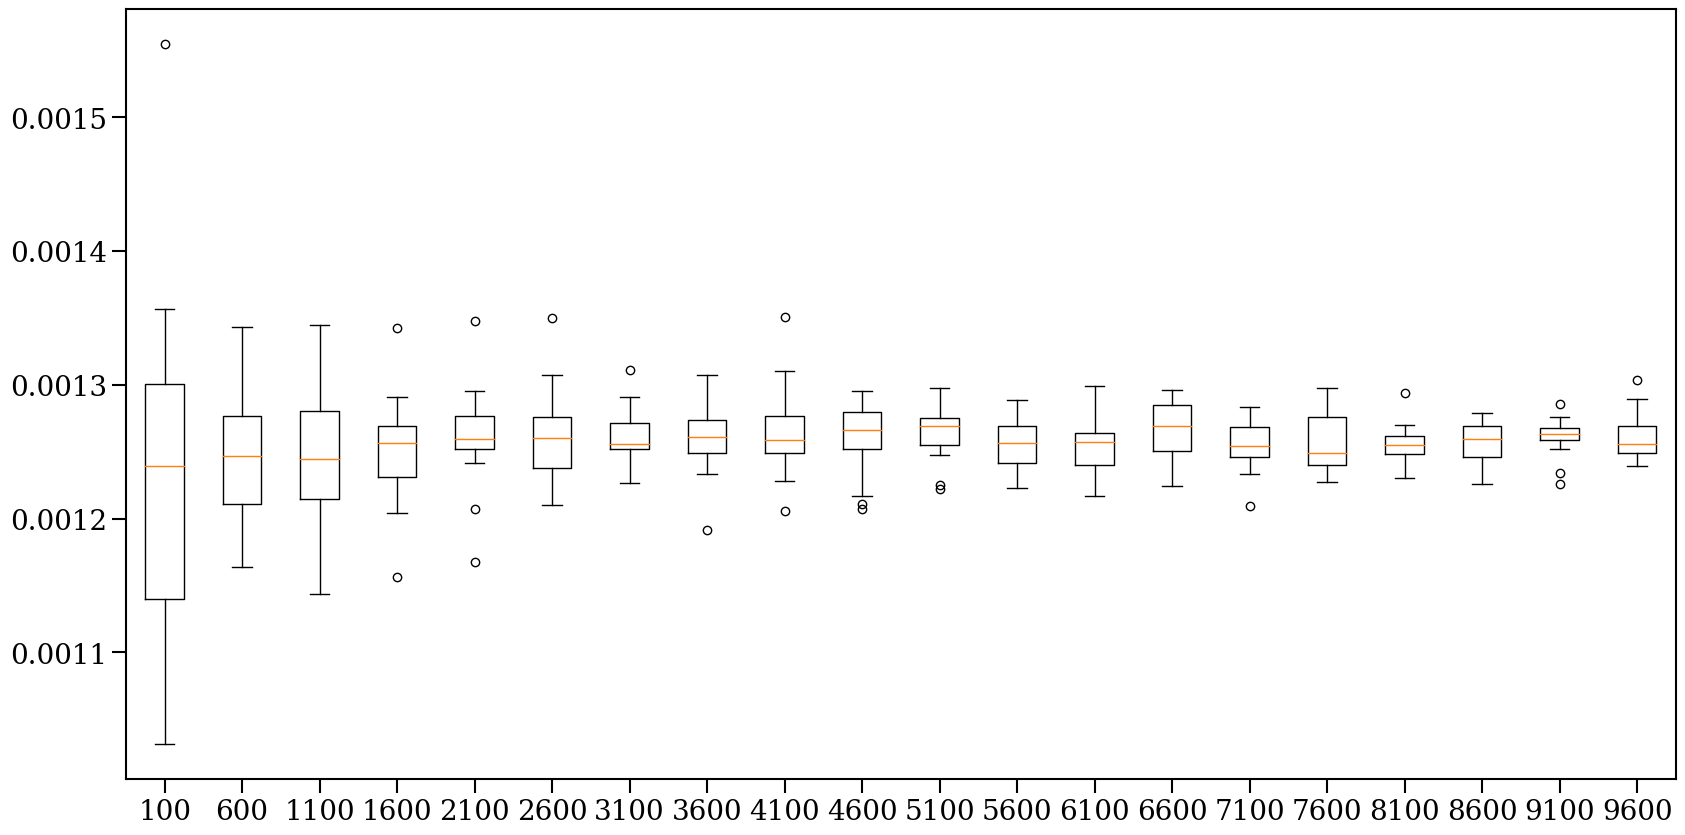

sample with 100 sample size,mean:0.0012322505934515338, standard deviation: 0.00011807263604193396
sample with 8100 sample size,mean:0.0012556147814073817, standard deviation: 1.3167471586389786e-05


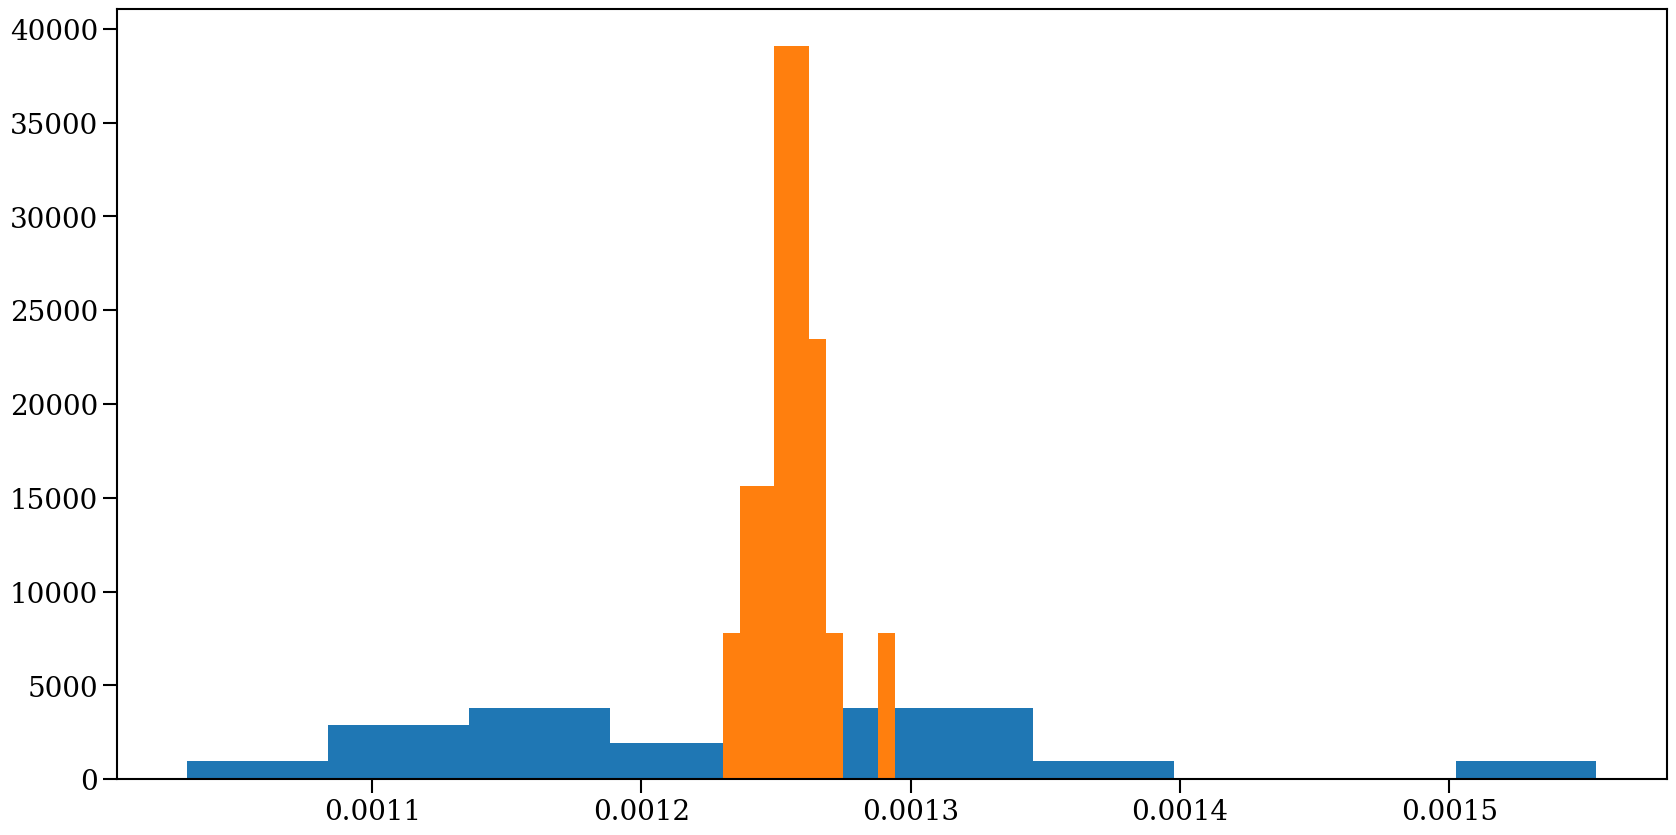

In [45]:
samplemeanlist = [] # list of sample mean                                                                   
l = [] # list of smaple size, for x-axis of box plots                                                       
numberofsample = 20 # number of sample in each sample size                                                  

# set sample size (i) between 100 to 8100, step by 500                                                      
for i in range(100,10000,500):
    # set x-axis                                                                                            
    l.append(i)
    # list of mean of each sample                                                                           
    ml = []
    # sample 50 time.                                                                                       
    for n in range(0,numberofsample):
        # random pick from population with sample size = i                                                  
        rs = random.choices(ew, k=i)
        # calculate the mean of each sample and save it in list of mean.                                    
        ml.append(sum(rs)/i)

    # save the 50 sample mean in samplemeanlist for box plots.                                              
    samplemeanlist.append(ml)
# set figure size                                                                                           
plt.figure(figsize=(20,10))
# plot box plots of each sample mean                                                                        
plt.boxplot(samplemeanlist,labels = l)
# show plot                                                                                                 
plt.show()

print("sample with 100 sample size," + \
      "mean:" + str(np.mean(samplemeanlist[0])) + \
      ", standard deviation: "+ str(np.std(samplemeanlist[0])))
print("sample with 8100 sample size," + \
      "mean:" + str(np.mean(samplemeanlist[16])) + \
      ", standard deviation: "+ str(np.std(samplemeanlist[16])))

histplot = plt.figure(figsize=(20,10))
plt.hist(samplemeanlist[0],10, density=True)
plt.hist(samplemeanlist[16], 10, density=True)
plt.show()

12.801505775664232


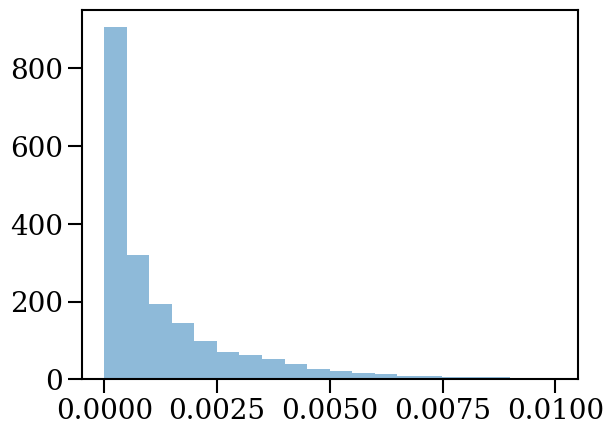

In [44]:
def generator(Ninput):
    ewcut=Emax
    fmax= few(Emin, B)
    xoutput=list(range(Ninput))
    youtput=list(range(Ninput))

    ii=0
    while ii<Ninput:
        rx=RNG.uniform(0,ewcut)
        ry=RNG.uniform(0,fmax)

        if ry<few(rx,B):
            xoutput[ii]=rx
            youtput[ii]=ry
            ii+=1
    return [xoutput,youtput]
N_exp=1
N=10000
E_gen =generator(N)
data=np.array(E_gen[0])
#print(E_gen)
#print(data)
#data=data/np.sum(data)
print(sum(data))

plt.hist(data, 20, density=True, alpha=0.5)
plt.show()


mean 0.0012636339322173375 var 5.520999210901963e-09 single exp var 1.7458932466442528e-07


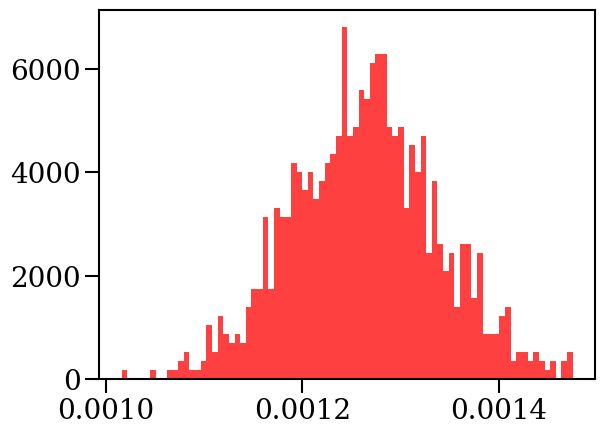

In [50]:
Nexp=1000
Nsim=500
eavg=list(range(Nexp))

for i in range(0,Nexp):
    edata=generator(Nsim)
    eavg[i]=sum(np.array(edata[0]))/len(np.array(edata[0]))
    
bin_entries, bin_edges, _ =plt.hist(eavg, 80, density=True, facecolor='r', alpha=0.75)
bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])
print("mean",np.mean(eavg),
"var",np.var(eavg),"single exp var",np.sqrt(Nexp)*np.var(eavg))

[1.26269849 0.0736683 ]
[[4.32168015e-06 3.03009375e-09]
 [3.03009375e-09 2.88639151e-06]]
[1.26269849e-03 7.36682981e-05]
[[4.32168015e-06 3.03009375e-09]
 [3.03009375e-09 2.88639151e-06]]


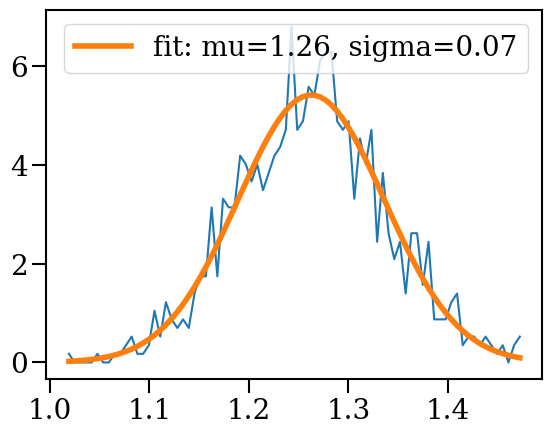

In [56]:
bin_centres = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])
import scipy.optimize as opt
C1=1000
popt, pcov = opt.curve_fit(Gaussian_dist, bin_centres*C1, bin_entries/C1)
plt.plot(bin_centres*C1,bin_entries/C1)
plt.plot(bin_centres*C1, Gaussian_dist(bin_centres*C1, *popt), lw=4,
         label='fit: mu=%.2f, sigma=%.2f' % tuple(popt))
plt.legend()
# plt.xlim([-1, 2])
print(popt)
print(pcov)
popt[0]/=C1
popt[1]/=C1
print(popt)
print(pcov)


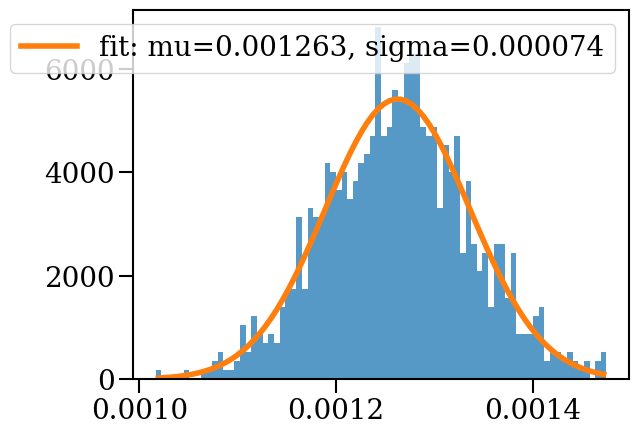

In [57]:
bin_entries, bin_edges, _ =plt.hist(eavg, 80, density=True,  alpha=0.75)
plt.plot(bin_centres, Gaussian_dist(bin_centres, *popt), lw=4,
         label='fit: mu=%f, sigma=%f' % tuple(popt))
plt.legend()
plt.show()

3.611060748642814e-08
0.009925666973293982
599.8169764577738
[[5.16896952e-02 5.16896952e-02 5.16896952e-02 ... 5.16896952e-02
  2.18534244e+01 5.16896952e-02]
 [1.21970088e+01 5.20684890e+00 4.82909037e-01 ... 4.82909037e-01
  8.32692178e+01 5.20684890e+00]
 [2.15614126e+01 9.31094558e+00 9.50170322e-01 ... 9.50170322e-01
  1.46483790e+02 1.45961801e+01]]


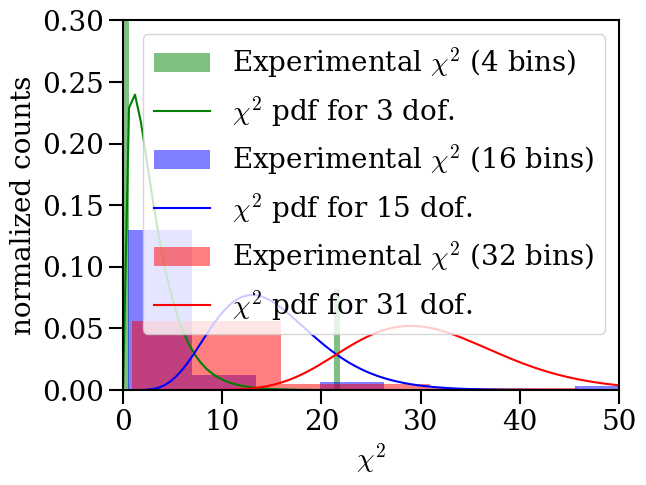

In [104]:
def FW(x,beta=B):
    return erf(np.sqrt(beta*x))#primitive

def Nominal_val(h,F=FW):
    
    exp_vals=[]
    for i in range(len(h[0])):
        # Compute the fraction of area of each bin                                                          
        # and then multiply per the normaliztion factor                                                     
        int_fraction = F(h[1][i+1]) - F(h[1][i])
        exp_vals.append(int_fraction*h[0].sum())
    return np.array(exp_vals)
nbins=[4,16,32]
chi_square=[]
print(min(data))
print(max(data))

for n in nbins:
    chis=[]
    # Loop over experiments                                                                                 
    for samp in data:
        # Fill the hist and compute theoretical number of observations                                      

        hist=np.histogram(samp,bins=n,range=(1*1e-9,0.02))
        nominal=get_nominal_val(hist)

        # Assuming that the bin content follows a poisson distribution                                      
        # compute the chi squared                                                                           
        sigmas=np.sqrt(hist[0])
        chis.append(np.sum(((hist[0]-nominal)**2)/nominal))
    chi_square.append(chis)
chi_square=np.array(chi_square)
x=np.linspace(0,chi_square.max(),1000)
print(chi_square.max())
                                                                                    
colors=['g','b','r']
print(chi_square)
for i, chiS in enumerate(chi_square):
    plt.hist(chiS, bins=40,density=True,alpha=0.5,color=colors[i],
             label='Experimental $\chi^2$ (%s bins)'%(nbins[i]));
    plt.plot(x,chi2.pdf(x,df=nbins[i]-1), c=colors[i],
             label='$\\chi^{2}$ pdf for %d dof.'%(nbins[i]-1))
    #plt.yscale('log')                                                                                      
plt.ylim(0,.3)
plt.xlim(0,50)
plt.legend()
plt.xlabel('$\\chi^{2}$')
plt.ylabel('normalized counts')
Text(0, 0.5, 'normalized counts')
plt.show()


In [48]:

def LLH(ektest,Btest):
    Loutput=0
    for i in range(0,len(ektest)):
        Loutput+=math.log(few(ektest[i],Btest))
    return -Loutput
print (LLH(ew,B))

Testimate= np.linspace(25,35,1336)

nL=len(Testimate)
L=list(range(nL))

for i in range(0,nL):
    L[i]=LLH(ew,1/(kbev*Testimate[i]))
print(L)
imin=L.index(min(L))
print (Testimate[imin],min(L))



-57911.971673466614
[-57849.177091620404, -57849.43039855653, -57849.68310531513, -57849.93521256958, -57850.18672099207, -57850.43763125436, -57850.68794402728, -57850.93765997981, -57851.18677978126, -57851.43530409942, -57851.68323360174, -57851.930568954056, -57852.177310821404, -57852.423459869315, -57852.66901676012, -57852.913982157246, -57853.15835672238, -57853.40214111639, -57853.64533599976, -57853.8879420311, -57854.12995986913, -57854.37139017159, -57854.61223359489, -57854.852490794816, -57855.09216242619, -57855.33124914328, -57855.56975159915, -57855.807670446404, -57856.045006336484, -57856.28175991995, -57856.51793184617, -57856.75352276498, -57856.98853332406, -57857.222964170636, -57857.456815951286, -57857.69008931109, -57857.92278489555, -57858.15490334819, -57858.38644531154, -57858.61741142911, -57858.84780234077, -57859.07761868818, -57859.30686111032, -57859.53553024651, -57859.76362673448, -57859.991151212045, -57860.21810431444, -57860.44448667848, -57860.67

/var/folders/yf/dg14jwgs5697ry5dqldd1ssm0000gn/T/ipykernel_40655/17853059.py:11: RuntimeWarning: invalid value encountered in sqrt
  return float(amp)/np.sqrt(x) * np.exp(-beta*x)
/var/folders/yf/dg14jwgs5697ry5dqldd1ssm0000gn/T/ipykernel_40655/17853059.py:11: RuntimeWarning: divide by zero encountered in true_divide
  return float(amp)/np.sqrt(x) * np.exp(-beta*x)


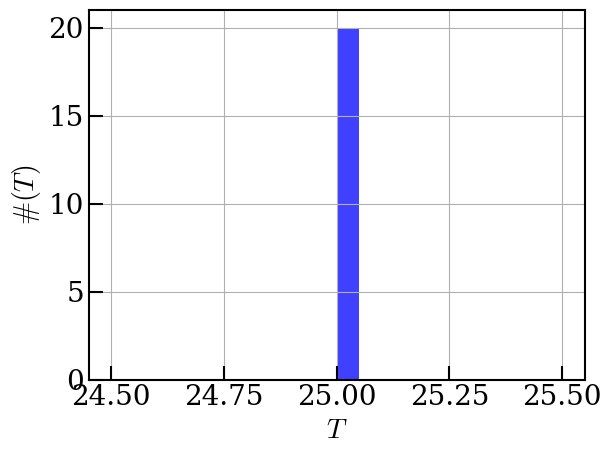

In [54]:
# Answer 6-4

def maxLLH(xestimate,testdata):
    ntest=len(xestimate)
    Ltest=list(range(ntest))
    for i in range(0,ntest):
        Ltest[i]=LLH(testdata,xestimate[i])
    ioutput=Ltest.index(min(Ltest))
    return xestimate[ioutput],ioutput
npar=1000
Nexp=2
Tfinal=list(range(Nexp))
ifinal=list(range(Nexp))

for i in range(0,Nexp):
    ew=ewgenerator(B)
    Tfinal[i],ifinal[i]=maxLLH(Testimate,ew)
    
plt.hist(Tfinal, 20, density=True, facecolor='b', alpha=0.75)

plt.xlabel(r'$T$')
plt.ylabel(r'$\#(T)$')
plt.tick_params(direction='in')
plt.grid(True)
plt.show()




In [25]:
def param_estimate(LL,xrange,delta=0.5):
    '''estimate parameter and its error'''
    #Scale LL                                                                                               
    sLL=LL-LL.min()

    # Best parameter                                                                                        
    imin=sLL.argmin()
    p=xrange[imin]

    # Estimate error by checking when sLL is equal to 0.5                                                   
    err_minus = np.interp(delta,np.flip(sLL[:imin]),np.flip(xrange[:imin]))
    err_plus  = np.interp(delta,sLL[imin:],xrange[imin:])
    err = (err_plus - err_minus)*0.5

    return p, err
print(gen_inv)
LL = []
T_range=np.linspace(25,35,1000)
for i in T_range:
    LL.append(logL(gen_inv))
LL=np.array(LL);

print(LL)



[2.22948971e-03 1.51337980e-05 2.25575770e-04 ... 5.54341851e-04
 1.73026276e-03 5.59743517e-03]
[[-4.59702692 -7.9502796  -6.51797594 ... -5.94118101 -4.91697707
  -2.83336689]
 [-4.59702692 -7.9502796  -6.51797594 ... -5.94118101 -4.91697707
  -2.83336689]
 [-4.59702692 -7.9502796  -6.51797594 ... -5.94118101 -4.91697707
  -2.83336689]
 ...
 [-4.59702692 -7.9502796  -6.51797594 ... -5.94118101 -4.91697707
  -2.83336689]
 [-4.59702692 -7.9502796  -6.51797594 ... -5.94118101 -4.91697707
  -2.83336689]
 [-4.59702692 -7.9502796  -6.51797594 ... -5.94118101 -4.91697707
  -2.83336689]]


In [89]:
T_est, T_err=param_estimate(LL,T_range)



IndexError: index 1337 is out of bounds for axis 0 with size 1336

In [91]:
def logspace(nx,beta=B,nsigma=10,minpow=-8):
    '''
    Define bin centers on which to evaluate the pdf
    considering that 1./beta is the scale of interest
    and that the sigma is ~1./(sqrt(2)*beta)
    '''
    sigma=1./(np.sqrt(2)*beta)
    return np.logspace(minpow,np.log10(sigma*nsigma),nx+2)

In [94]:
nbins=50
hrange=logspace(100)
hist=np.histogram(samp,bins=hrange)

# Compute goodness of a fit for various T
T_range=np.linspace(20,50,1000)
chi_square=[]

for t in T_range:
    exp_val=get_nominal_val(hist,lambda x : FW(x,1./(t*kbev)))
    chi_square.append(((hist[0]-exp_val)**2/(exp_val*(1-(exp_val/hist[0].sum())))).sum())
chi_square=np.array(chi_square)

chi_square2=[]
for t in T_range:
    exp_val=(hist,lambda x : FW(x,1./(t*kbev)))
    chi_square2.append(
        np.sum(
            ((samp.mean() - 0.5*kbev*t)/(samp.std()))**2
        )
    )
chi_square2=np.array(chi_square2)

/var/folders/yf/dg14jwgs5697ry5dqldd1ssm0000gn/T/ipykernel_25861/182970225.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  ((samp.mean() - 0.5*kbev*t)/(samp.std()))**2


(-0.2, 5.0)

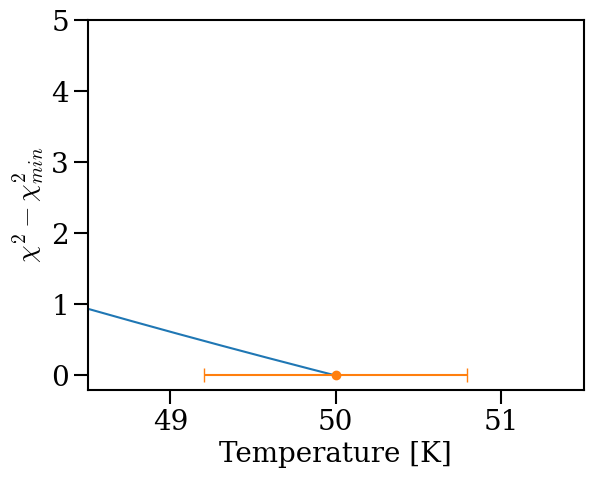

In [96]:
T_est2, T_err2=param_estimate(chi_square,T_range,1)

# Plot the ChiSquared
y_chi=chi_square-chi_square.min()
plt.plot(T_range,y_chi)
plt.errorbar(T_est2,y_chi.min(),xerr=T_err2,fmt='o',ms=6, capsize=5,
            label='Estimated Temperature: (%.2f +/- %.2f) K'%(T_est2,T_err2))

plt.ylabel('$\\chi^2 - \\chi^2_{min}$')
plt.xlabel('Temperature [K]')
plt.xlim(T_est2-1.5,T_est2+1.5)
plt.ylim(-.2,5)
#plt.yscale('log')
#plt.legend();

In [100]:
# From the knowledge of the expected mean value (kbT/2)
# We can then estimate the temperature as follows

# Define the inverse function, an generate data
inv_exp=lambda x: -np.log(x)*(1./B)
 

# apply the u(x) function
u_x=np.sqrt(gen_inv/(np.pi*B))

## Compute the Average and the error on the average
T_est3 = 2*u_x.mean()/kbev
T_err3 = 2*u_x.std()/(kbev*np.sqrt(u_x.shape[0]))
print('Estimated Temperature: (%.2f +/- %.2f) K'%(T_est3,T_err3))

Estimated Temperature: (19.21 +/- 0.15) K


In [101]:
def plot_T_est(t,terr,nm, ms=8):
    return plt.errorbar(t, nm, xerr=terr, fmt='o',ms=ms, color='k', capsize=5, elinewidth=2, capthick=2)

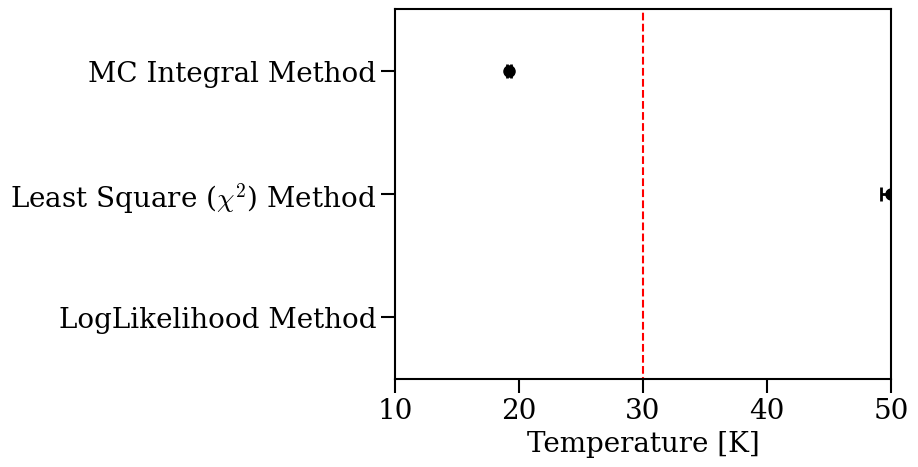

In [105]:
# Plot all the estimated parameters together
labels=[
    'LogLikelihood Method',
    'Least Square ($\\chi^2$) Method',
    'MC Integral Method',
]

plt.plot([30,30],[0,4],'--',c='r')
#plot_T_est(T_est, T_err,1)
plot_T_est(T_est2, T_err2,2)
plot_T_est(T_est3, T_err3,3)

plt.ylim(0.5,3.5)
plt.xlim(10,50)
plt.yticks([1,2,3],labels=labels)
plt.xlabel('Temperature [K]');